In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pyuvdata import UVData
import hera_pspec as hp
from hera_pspec.data import DATA_PATH
import os

In [11]:
path = '/data4/paper/HERA19Golden/CalibratedData/2457548/LSThrs_20.0_23.0/'
uvd = UVData()
uvd.read_uvh5(path+'zen.2457548.55673_66112.xx.HH.uvcRPC.uvh5')

In [12]:
lowband = (150,350)
highband = (530,730)

In [13]:
uvd.flag_array.shape

(150138, 1, 1024, 1)

MemoryError: 

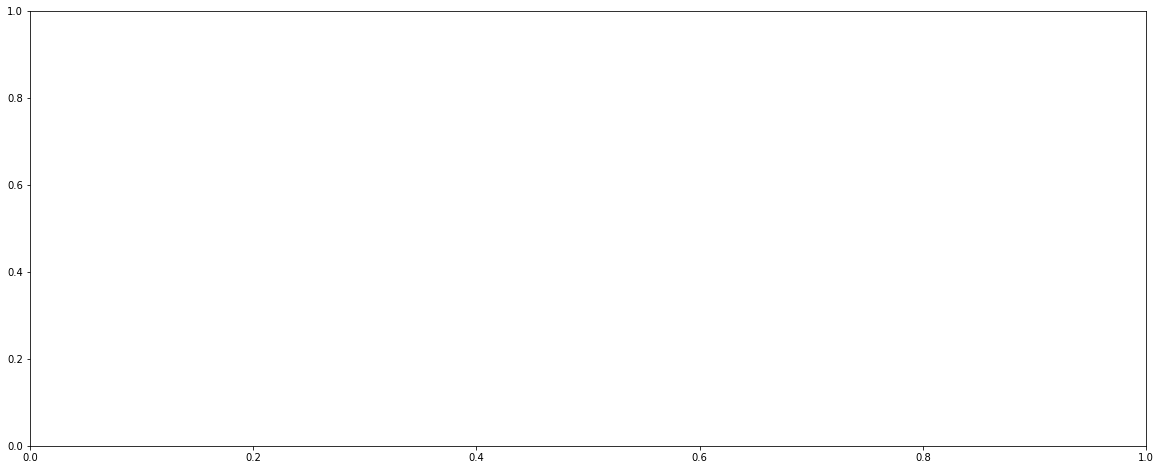

In [15]:
plt.figure(figsize=(20,8))
plt.imshow(uvd.flag_array.squeeze(),aspect='auto')
plt.axvline(lowband[0],color='red')
plt.axvline(lowband[1],color='red')
plt.axvline(highband[0],color='red')
plt.axvline(highband[1],color='red')
plt.show()

In [9]:
low = hp.flags.construct_factorizable_mask([uvd],spw_ranges=[lowband],first='row',greedy_threshold=1.e-6)[0]
high = hp.flags.construct_factorizable_mask([uvd],spw_ranges=[highband],first='row',greedy_threshold=1.e-6)[0]

MemoryError: 

In [7]:
plt.figure(figsize=(20,8))
plt.imshow(low.flag_array.squeeze(),aspect='auto')
plt.axvline(lowband[0],color='red')
plt.axvline(lowband[1],color='red')
plt.axvline(highband[0],color='red')
plt.axvline(highband[1],color='red')
plt.show()

MemoryError: 

<Figure size 1440x576 with 1 Axes>

MemoryError: 

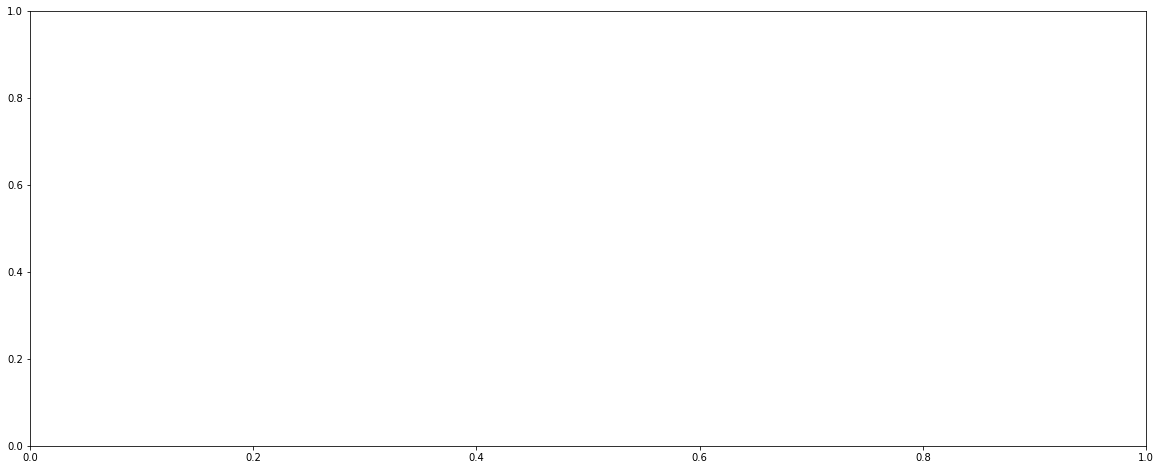

In [8]:
plt.figure(figsize=(20,8))
plt.imshow(high.flag_array.squeeze(),aspect='auto')
plt.axvline(lowband[0],color='red')
plt.axvline(lowband[1],color='red')
plt.axvline(highband[0],color='red')
plt.axvline(highband[1],color='red')
plt.show()

In [ ]:
pol = 'xx'
beamfile = os.path.join(DATA_PATH, 'HERA_NF_dipole_power.beamfits')
cosmo = hp.conversions.Cosmo_Conversions()
uvb = hp.pspecbeam.PSpecBeamUV(beamfile, cosmo=cosmo)

# Convert to cosmological units (mK)
Jy_to_mK = uvb.Jy_to_mK(np.unique(uvd.freq_array), pol=pol)

In [ ]:
bl1 = (9,20)
bl2 = (9,20)
blp = (bl1,bl2)
blpairs = [[blp,]]

In [ ]:
def MakeUVP(uvd, Jy_to_mK, spw):

    uvd.data_array *= Jy_to_mK[None, None, :, None]
    
    # Shift data and load datasets
    uvd1 = uvd.select(times=np.unique(uvd.time_array)[:-1:2], inplace=False)
    uvd2 = uvd.select(times=np.unique(uvd.time_array)[1::2], inplace=False)
    ds = hp.PSpecData(dsets=[uvd1, uvd2], wgts=[None, None], beam=uvb)

    # Set visibility units
    ds.dsets[0].vis_units = 'mK'
    ds.dsets[1].vis_units = 'mK'

    # Phase data (What does this do?)
    ds.rephase_to_dset(0)
    
    uvp = ds.pspec(
        [(9,20)],
        [(9,20)],
        (0, 1),
        pols=[('xx', 'xx')],
        spw_ranges=spw,
        taper="blackman-harris",
        verbose=True)
    
    return uvp

In [12]:
uvp_high = MakeUVP(high, Jy_to_mK,[highband])
uvp_low = MakeUVP(low, Jy_to_mK, [lowband])
uvp_low_unflag = MakeUVP(uvd, Jy_to_mK, [lowband])
uvp_high_unflag = MakeUVP(uvd, Jy_to_mK, [highband])


Setting spectral range: (530, 730)

Using polarization pair: ('xx', 'xx')

(bl1, bl2) pair: ((9, 20), (9, 20))
pol: (-5, -5)
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

Setting spectral range: (150, 350)

Using polarization pair: ('xx', 'xx')

(bl1, bl2) pair: ((9, 20), (9, 20))
pol: (-5, -5)
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

Setting spectral range: (150, 350)

Using polarization pair: ('xx', 'xx')

(bl1, bl2) pair: ((9, 20), (9, 20))
pol: (-5, -5)
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

Setting spectral range: (530, 730)

Using polarization pair: ('xx', 'xx')

(bl1, bl2) pair: ((9, 20), (9, 20))
pol: (-5, -5)
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...


In [109]:
%%time
# Average the power spectra
uvp_high_avg = uvp_high.average_spectra(blpair_groups=blpairs, time_avg=True, inplace=False)
key = (0, uvp_high_avg.blpair_array[0], 'xx') # key = (spw, blpair, pol)
ps_high_avg = np.abs(np.real(uvp_high_avg.get_data(key)).squeeze())
print ps_high_avg.shape

(200,)
CPU times: user 15.5 ms, sys: 1.21 ms, total: 16.7 ms
Wall time: 14.7 ms


In [79]:
# Get k's
k_high_perp, k_high_para = uvp_high.get_kperps(0, little_h=True), uvp_high.get_kparas(0, little_h=True)
k_low_perp, k_low_para = uvp_low.get_kperps(0, little_h=True), uvp_low.get_kparas(0, little_h=True)

In [101]:
# Estimate thermal noise
Tsys = 3000.
P_N_high_avg = uvp_high_avg.generate_noise_spectra(0, 'xx', Tsys)[uvp_high.antnums_to_blpair(blp)].T
P_N_high = uvp_high.generate_noise_spectra(0, 'xx', Tsys)[uvp_high.antnums_to_blpair(blp)].T
print P_N_high.shape
print P_N_high_avg.shape
print np.min(P_N_high[np.isfinite(P_N_high)])
print np.nanmax(P_N_high[np.isfinite(P_N_high)])

(200, 439)
(200, 1)
19063624178407.402
19063624178407.402


In [108]:
uvp_high_avg.generate_noise_spectra?

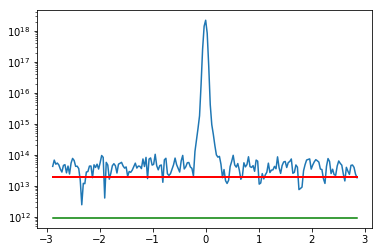

In [102]:
plt.semilogy(k_high_para,ps_high_avg)
plt.semilogy(k_high_para,P_N_high,color='red')
plt.semilogy(k_high_para,P_N_high_avg,color='green')
plt.show()

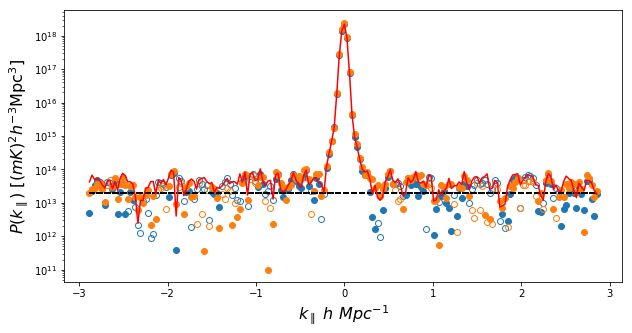

In [104]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
hp.plot.delay_spectrum(uvp_high, [((9,20),(9,20))], 0, 'xx', average_blpairs=True, average_times=True, 
                       legend=False, delay=False, ax = ax, markers=True, plot_noise=True, lines=False)
hp.plot.delay_spectrum(uvp_high_unflag, [((9,20),(9,20))], 0, 'xx', average_blpairs=True, average_times=True, 
                           legend=False, delay=False, ax = ax, markers=True, plot_noise=True, lines=False)
ax.plot(k_para,P_N_high,color='black',linestyle='--')
plt.semilogy(k_high_para,ps_high_avg,color='red')
plt.show()

[]

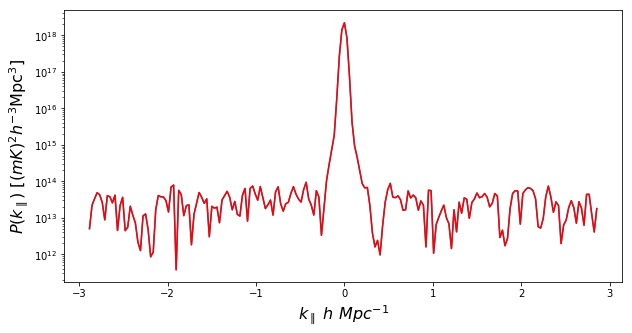

In [110]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
hp.plot.delay_spectrum(uvp_high, [((9,20),(9,20))], 0, 'xx', average_blpairs=True, average_times=True, 
                       legend=False, delay=False, ax = ax)
plt.semilogy(k_high_para,ps_high_avg,color='red')
plt.plot()

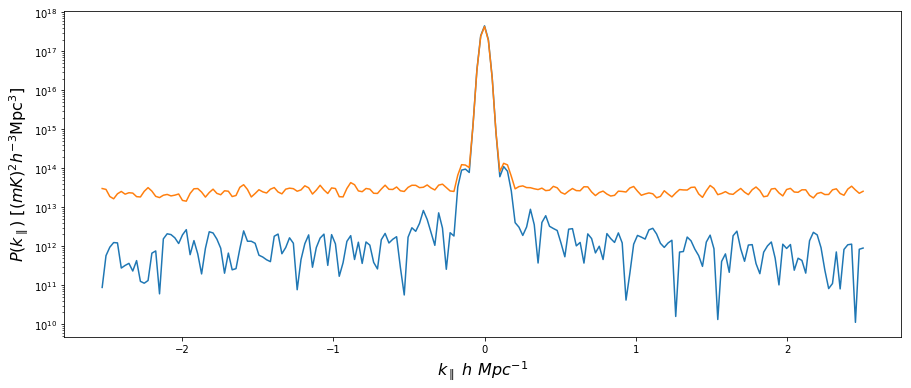

In [34]:
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(111)
# I guess the above is the thing I should have been doing all these years, but it seems so dumb
hp.plot.delay_spectrum(uvp_low, [((9,20),(9,20))], 0, 'xx', average_blpairs=True, average_times=True, 
                            legend=False, delay=False, ax = ax)
hp.plot.delay_spectrum(uvp_low_unflag, [((9,20),(9,20))], 0, 'xx', average_blpairs=True, average_times=True, 
                       legend=False, delay=False, ax = ax)
plt.show()

In [ ]:
# Estimate the bootstrap errors
# Set the random seed
np.random.seed(10)

In [70]:
blpairs = [[blp,]]
for b in blpairs:
    print b

[((9, 20), (9, 20))]


In [71]:
# Generate a bootstrap sample of the averaged power spectrum
uvp_boot_list, boot_wgts = hp.grouping.bootstrap_average_blpairs(uvp_list=[uvp_high,], blpair_groups=blpairs, 
                                                                 time_avg=True)

# uvp_boot_list is a list of UVPSpec objects with the same length as the input list (uvp_list)
print len(uvp_boot_list)
print uvp_boot_list[0].blpair_array

1
[109120109120]


In [65]:
hp.plot.delay_spectrum?

In [72]:
pwd

u'/data4/paper/HERA19Golden/kohn18_analysis'